# Imports

In [155]:
import numpy as np
import pandas as pd


In [156]:
import re
from string import punctuation
import emoji

In [157]:
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, SimpleRNN, GRU

In [158]:
import matplotlib.pyplot as plt

In [159]:
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Vars definition

In [87]:
n_gram = 4
window_size = 5
percent_sample = 0.01

In [88]:
stop_words = set(stopwords.words("english"))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Data preparation

## Initial clean

In [89]:
df = pd.read_csv("data/data.csv")
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
...,...,...,...,...,...,...,...
24108,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,MSI Laptop is high performance and the best. c...
24109,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,Excellent performance best laptop.
24110,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,4,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...,4.4,7,2,3,Nice,The product does not support facial recognitio...


In [90]:
df = df.sample(frac=percent_sample)
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
11073,SAMSUNG Galaxy Book4 Intel Core i5 13th Gen 13...,4.5,"3,767",335,5,Just wow!,I bought it on sale with a bank offer for 46k ...
13574,ASUS Chromebook Intel Celeron Dual Core N4500 ...,3.7,"1,910",172,3,Does the job,on off issue
2915,Lenovo IdeaPad Slim 1 AMD Ryzen 5 Hexa Core 55...,4.2,"5,705",501,3,Just okay,Everything is working fine.... battery sometim...
8605,MSI Thin 15 Intel Core i5 12th Gen 12450H - (1...,4.3,"1,046",95,4,Nice product,It's good laptop we can run heavy application....
23242,HP Laptop 15s Intel Celeron Dual Core Intel Ce...,3.7,124,13,5,Must buy!,Flip Card is the best commerce site 🔥🔥☺
...,...,...,...,...,...,...,...
6031,ASUS Vivobook 15 Intel Core i3 12th Gen 1215U ...,4.3,"9,156",698,4,Worth the money,Really liked the product! But battery life isn...
21719,ASUS Chromebook Intel Celeron Dual Core N3350 ...,3.5,"1,348",158,5,Must buy!,This is a legendry thing\r\nIts tchpad is so s...
12470,Acer Swift Go 14 AMD Ryzen 7 Octa Core 7730U -...,4.3,348,39,5,Super!,Nice and lightweight product
2216,Lenovo Chromebook MediaTek Kompanio 520 - (4 G...,3.7,660,42,5,Great product,I wasn't very satisfied with the kind of displ...


In [91]:
df_review = df[["review"]]
df_review

,review
11073,I bought it on sale with a bank offer for 46k ...
13574,on off issue
2915,Everything is working fine.... battery sometim...
8605,It's good laptop we can run heavy application....
23242,Flip Card is the best commerce site 🔥🔥☺
...,...
6031,Really liked the product! But battery life isn...
21719,This is a legendry thing\r\nIts tchpad is so s...
12470,Nice and lightweight product
2216,I wasn't very satisfied with the kind of displ...


In [92]:
def clean_text_dataframe(
    df_i: pd.DataFrame,
    columns: list[str] | None = None,
    keep_apostrophe: bool = True,
    min_words: int = n_gram,
) -> pd.DataFrame:
    """
    Очищает текст и удаляет строки с малым количеством слов

    Params:
        df (pd.DataFrame): Исходный DataFrame
        columns (list[str]|None): Столбцы для обработки (None = все строковые)
        keep_apostrophe (bool): Сохранять апострофы (по умолчанию True)
        min_words (int): Минимальное количество слов для сохранения строки

    Return:
        pd.DataFrame: Очищенная и отфильтрованная копия DataFrame
    """
    df_clean = df_i.copy()

    # Определение целевых столбцов
    if columns is None:
        columns = df_clean.select_dtypes(include=["object", "string"]).columns.tolist()

    # Настройка паттерна для пунктуации
    punct_pattern = r"[{}]".format(
        re.escape(
            punctuation.replace("'", "") if keep_apostrophe else re.escape(punctuation)
        )
    )

    def text_cleaner(text):
        if not isinstance(text, str):
            return text

        # Удаление эмодзи
        text = emoji.replace_emoji(text, replace="")

        # Удаление пунктуации
        text = re.sub(punct_pattern, " ", text)

        # Удаление спецсимволов
        text = re.sub(r"[^a-zA-Z0-9\'\s]", " ", text)

        # Нормализация пробелов
        text = re.sub(r"\s+", " ", text).strip()

        return text

    for col in columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(text_cleaner)

    word_count_mask = (
        df_clean[columns]
        .apply(lambda col: col.str.split().str.len() > min_words)
        .all(axis=1)
    )

    df_clean = df_clean[word_count_mask].reset_index(drop=True)

    return df_clean

In [93]:
df_review = clean_text_dataframe(df_review, min_words=n_gram)
df_review

,review
0,I bought it on sale with a bank offer for 46k ...
1,Everything is working fine battery sometimes s...
2,It's good laptop we can run heavy application ...
3,Flip Card is the best commerce site
4,Overall product is good Display 3 Battery 4 7 ...
...,...
154,Battery backup is like Max 6 hour
155,Really liked the product But battery life isn'...
156,This is a legendry thing Its tchpad is so sens...
157,I wasn't very satisfied with the kind of displ...


## Data tokenize

In [94]:
def tokenize_text_dataframe(df_i: pd.DataFrame, tokenizer):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(
            lambda col: [
                word for word in tokenizer(col.lower()) if word not in stop_words
            ]
        )
    )

In [95]:
df_tokens = tokenize_text_dataframe(
    df_review, TweetTokenizer(match_phone_numbers=False).tokenize
)
df_tokens

,review
0,"[bought, sale, bank, offer, 46k, 16gb, best, l..."
1,"[everything, working, fine, battery, sometimes..."
2,"[good, laptop, run, heavy, application, one, t..."
3,"[flip, card, best, commerce, site]"
4,"[overall, product, good, display, 3, battery, ..."
...,...
154,"[battery, backup, like, max, 6, hour]"
155,"[really, liked, product, battery, life, really..."
156,"[legendry, thing, tchpad, sensetive, keyboard,..."
157,"[satisfied, kind, display, keyboard, touchpad,..."


In [96]:
df_tokens = df_tokens[df_tokens["review"].apply(lambda col: len(col) > n_gram)].reset_index(drop=True)
df_tokens

,review
0,"[bought, sale, bank, offer, 46k, 16gb, best, l..."
1,"[everything, working, fine, battery, sometimes..."
2,"[good, laptop, run, heavy, application, one, t..."
3,"[flip, card, best, commerce, site]"
4,"[overall, product, good, display, 3, battery, ..."
...,...
131,"[first, pc, bought, big, billion, day, 39k, ov..."
132,"[battery, backup, like, max, 6, hour]"
133,"[really, liked, product, battery, life, really..."
134,"[legendry, thing, tchpad, sensetive, keyboard,..."


In [97]:
def vocab_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(df_i.iloc[:, 0].apply(lambda col: sorted(set(col))))


def idx_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(lambda col: {word: idx for idx, word in enumerate(col)})
    )


def global_idx_text_dataframe(df_i: pd.DataFrame):
    """
    Создаёт словарь {слово: индекс} для всех уникальных слов
    из объединённой первой колонки DataFrame, сохраняя порядок появления слов.
    Возвращает DataFrame с одним словарём в виде строки.
    """
    # Объединяем все элементы из первой колонки в один список
    all_words = sum(df_i.iloc[:, 0].tolist(), [])

    # Удаляем дубликаты с сохранением порядка первого появления
    unique_words = list(set(all_words))

    # Создаём итоговый словарь {слово: индекс}
    combined_dict = {word: idx for idx, word in enumerate(unique_words)}

    return pd.DataFrame(list(combined_dict.items()), columns=["Word", "Index"])

In [98]:
df_vocab = vocab_text_dataframe(df_tokens)
df_word_to_idx = idx_text_dataframe(df_vocab)
df_global_word_to_idx = global_idx_text_dataframe(df_vocab)

In [99]:
df_word_to_idx

,review
0,"{'16gb': 0, '46k': 1, 'amazing': 2, 'bank': 3,..."
1,"{'2': 0, '6': 1, 'backlit': 2, 'backup': 3, 'b..."
2,"{'64': 0, 'application': 1, 'battery': 2, 'gb'..."
3,"{'best': 0, 'card': 1, 'commerce': 2, 'flip': ..."
4,"{'2': 0, '3': 1, '4': 2, '7': 3, 'apps': 4, 'b..."
...,...
131,"{'39k': 0, '6': 1, '7': 2, 'amazing': 3, 'arou..."
132,"{'6': 0, 'backup': 1, 'battery': 2, 'hour': 3,..."
133,"{'battery': 0, 'good': 1, 'life': 2, 'liked': ..."
134,"{'also': 0, 'ar': 1, 'average': 2, 'awesome': ..."


In [100]:
df_vocab

,review
0,"[16gb, 46k, amazing, bank, base, battery, bed,..."
1,"[2, 6, backlit, backup, battery, everything, f..."
2,"[64, application, battery, gb, good, heavy, la..."
3,"[best, card, commerce, flip, site]"
4,"[2, 3, 4, 7, apps, battery, codings, design, d..."
...,...
131,"[39k, 6, 7, amazing, around, awesome, backligh..."
132,"[6, backup, battery, hour, like, max]"
133,"[battery, good, life, liked, product, really]"
134,"[also, ar, average, awesome, buy, good, keyboa..."


In [101]:
df_word_to_idx

,review
0,"{'16gb': 0, '46k': 1, 'amazing': 2, 'bank': 3,..."
1,"{'2': 0, '6': 1, 'backlit': 2, 'backup': 3, 'b..."
2,"{'64': 0, 'application': 1, 'battery': 2, 'gb'..."
3,"{'best': 0, 'card': 1, 'commerce': 2, 'flip': ..."
4,"{'2': 0, '3': 1, '4': 2, '7': 3, 'apps': 4, 'b..."
...,...
131,"{'39k': 0, '6': 1, '7': 2, 'amazing': 3, 'arou..."
132,"{'6': 0, 'backup': 1, 'battery': 2, 'hour': 3,..."
133,"{'battery': 0, 'good': 1, 'life': 2, 'liked': ..."
134,"{'also': 0, 'ar': 1, 'average': 2, 'awesome': ..."


In [102]:
df_global_word_to_idx

,Word,Index
0,price,0
1,directly,1
2,feels,2
3,service,3
4,meaning,4
...,...,...
941,compact,941
942,though,942
943,body,943
944,delivery,944


In [103]:
tokens = df_tokens.iloc[:, 0].to_list()
vocab = df_vocab.iloc[:, 0].to_list()
global_vocab = list(sorted(set([item for sublist in vocab for item in sublist])))
vocab_size = len(global_vocab)
word_to_idx = df_word_to_idx.iloc[:, 0].to_list()
global_word_to_idx = {
    v: k for k, v in df_global_word_to_idx.iloc[:, 0].to_dict().items()
}
global_idx_to_word = {v: k for k, v in global_word_to_idx.items()} 

In [104]:

word_to_idx

[{'16gb': 0,
  '46k': 1,
  'amazing': 2,
  'bank': 3,
  'base': 4,
  'battery': 5,
  'bed': 6,
  'best': 7,
  'bought': 8,
  'build': 9,
  'coming': 10,
  'decent': 11,
  'full': 12,
  'good': 13,
  'grill': 14,
  'lap': 15,
  'laptop': 16,
  'like': 17,
  'macbook': 18,
  'much': 19,
  'offer': 20,
  'one': 21,
  'overall': 22,
  'performance': 23,
  'present': 24,
  'price': 25,
  'problem': 26,
  'properly': 27,
  'quality': 28,
  'range': 29,
  'sale': 30,
  'sound': 31,
  'speaker': 32,
  'table': 33,
  'use': 34,
  'vibe': 35},
 {'2': 0,
  '6': 1,
  'backlit': 2,
  'backup': 3,
  'battery': 4,
  'everything': 5,
  'fine': 6,
  'hours': 7,
  'keyboard': 8,
  'missing': 9,
  'showing': 10,
  'sometimes': 11,
  'working': 12},
 {'64': 0,
  'application': 1,
  'battery': 2,
  'gb': 3,
  'good': 4,
  'heavy': 5,
  'laptop': 6,
  'look': 7,
  'msi': 8,
  'one': 9,
  'part': 10,
  'ram': 11,
  'rest': 12,
  'run': 13,
  'thing': 14},
 {'best': 0, 'card': 1, 'commerce': 2, 'flip': 3, 'si

In [105]:
global_word_to_idx

{'price': 0,
 'directly': 1,
 'feels': 2,
 'service': 3,
 'meaning': 4,
 '1080': 5,
 'hrs': 6,
 'bank': 7,
 'vivid': 8,
 'go': 9,
 'rate': 10,
 'wi': 11,
 'giving': 12,
 'weak': 13,
 'days': 14,
 'chromebook': 15,
 'since': 16,
 '4k': 17,
 'thi': 18,
 'affordable': 19,
 'ample': 20,
 'notebook': 21,
 'upto': 22,
 'ugly': 23,
 'regret': 24,
 'opted': 25,
 'get': 26,
 'date': 27,
 'desktop': 28,
 'matter': 29,
 'studying': 30,
 'card': 31,
 'months': 32,
 'boost': 33,
 'bios': 34,
 'inch': 35,
 'also': 36,
 'easy': 37,
 'instead': 38,
 'line': 39,
 'ordered': 40,
 'commendable': 41,
 'quality': 42,
 '48k': 43,
 'buying': 44,
 'engineers': 45,
 'glare': 46,
 'hate': 47,
 'classes': 48,
 'codings': 49,
 'locked': 50,
 'soo': 51,
 'seconds': 52,
 'clean': 53,
 'long': 54,
 'school': 55,
 'year': 56,
 'gameplay': 57,
 'amd': 58,
 'cannot': 59,
 'launched': 60,
 'deal': 61,
 'backside': 62,
 'defective': 63,
 'solid': 64,
 'compared': 65,
 'liked': 66,
 'day': 67,
 'rapidly': 68,
 'port': 69,

In [106]:
vocab

[['16gb',
  '46k',
  'amazing',
  'bank',
  'base',
  'battery',
  'bed',
  'best',
  'bought',
  'build',
  'coming',
  'decent',
  'full',
  'good',
  'grill',
  'lap',
  'laptop',
  'like',
  'macbook',
  'much',
  'offer',
  'one',
  'overall',
  'performance',
  'present',
  'price',
  'problem',
  'properly',
  'quality',
  'range',
  'sale',
  'sound',
  'speaker',
  'table',
  'use',
  'vibe'],
 ['2',
  '6',
  'backlit',
  'backup',
  'battery',
  'everything',
  'fine',
  'hours',
  'keyboard',
  'missing',
  'showing',
  'sometimes',
  'working'],
 ['64',
  'application',
  'battery',
  'gb',
  'good',
  'heavy',
  'laptop',
  'look',
  'msi',
  'one',
  'part',
  'ram',
  'rest',
  'run',
  'thing'],
 ['best', 'card', 'commerce', 'flip', 'site'],
 ['2',
  '3',
  '4',
  '7',
  'apps',
  'battery',
  'codings',
  'design',
  'development',
  'display',
  'gaming',
  'good',
  'laptop',
  'many',
  'minimal',
  'overall',
  'performance',
  'product',
  'software',
  'students'

In [107]:
global_vocab

['0',
 '1',
 '10',
 '1080',
 '1080p',
 '11',
 '120',
 '1215u',
 '12th',
 '13',
 '14',
 '1440p',
 '14s',
 '15',
 '16',
 '165',
 '16gb',
 '197',
 '1st',
 '2',
 '20',
 '2023',
 '2050',
 '23',
 '24',
 '25',
 '250nits',
 '2k',
 '3',
 '30',
 '300',
 '3050',
 '30k',
 '35k',
 '38whr',
 '39k',
 '4',
 '400',
 '4060',
 '40k',
 '45k',
 '45plus',
 '45w',
 '46k',
 '47000',
 '48k',
 '4k',
 '5',
 '500',
 '512',
 '54',
 '5k',
 '5kgs',
 '6',
 '60k',
 '61k',
 '64',
 '65',
 '7',
 '70k',
 '720',
 '8',
 '8kg',
 '8kgs',
 '9',
 '9th',
 'aaa',
 'academic',
 'acceptable',
 'access',
 'accessory',
 'according',
 'accuracy',
 'acer',
 'across',
 'actually',
 'adaptor',
 'add',
 'added',
 'additional',
 'additionally',
 'afford',
 'affordability',
 'affordable',
 'ago',
 'ally',
 'almost',
 'already',
 'alright',
 'als',
 'also',
 'although',
 'always',
 'amazing',
 'amd',
 'amoled',
 'ample',
 'android',
 'another',
 'anti',
 'anything',
 'anyway',
 'app',
 'application',
 'appreciate',
 'apps',
 'ar',
 'arise',


## Token preparation

### BoW

In [108]:
corpus, y_bow = [], []
for idx, cur_token in enumerate(tokens
                                # [: 2 * len(tokens) // 3]
                                ):
    for i in range(len(cur_token) - window_size):
        context = cur_token[i : i + window_size]
        corpus.append(" ".join(context))
        y_bow.append(global_word_to_idx[cur_token[i + window_size]])
        # y_bow.append(word_to_idx[idx][cur_token[i + window_size]])

vectorizer = CountVectorizer(vocabulary=global_vocab)
X_bow = vectorizer.fit_transform(corpus).toarray()
y_bow = np.array(y_bow)

#### df

In [109]:
# df_bow = pd.DataFrame({"x": X_bow.tolist(), "y": y_bow.tolist()})
# df_bow

### N-gram

In [110]:
mass_sequences = []
for idx, cur_token in enumerate(tokens):
    mass_sequences.append([])
    for i in range(len(cur_token) - n_gram + 1):
        mass_sequences[idx].append(cur_token[i : i + n_gram])

X_ngram, y_ngram = [], []
for idx, sequences in enumerate(mass_sequences):
    for seq in sequences:
        # print(seq, word_to_idx)
        X_ngram.append([global_word_to_idx[word] for word in seq[:-1]])
        y_ngram.append(global_word_to_idx[seq[-1]])
        # X_ngram.append([word_to_idx[idx][word] for word in seq[:-1]])
        # y_ngram.append(word_to_idx[idx][seq[-1]])

X_ngram = np.array(X_ngram)
y_ngram = np.array(y_ngram)

#### df

In [111]:
# df_ngram = pd.DataFrame({"x": X_ngram.tolist(), "y": y_ngram.tolist()})
# df_ngram

## Data split

In [112]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_bow, test_size=0.2
)

In [113]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(
    X_ngram, y_ngram, test_size=0.2
)

In [114]:
X_train_ng[0], y_train_ng[0]

(array([801, 198, 314]), np.int64(353))

In [115]:
X_train_ng.shape, y_train_ng.shape

((1762, 3), (1762,))

In [116]:
X_test_ng[0], y_test_ng[0]


(array([643,  26,  61]), np.int64(441))

In [117]:
X_test_ng.shape, y_test_ng.shape

((441, 3), (441,))

In [118]:
X_train_bow[0], y_train_bow[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [119]:
X_train_bow.shape, y_train_bow.shape

((1544, 946), (1544,))

In [120]:
X_test_bow[0], y_test_bow[0]


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [121]:
X_test_bow.shape, y_test_bow.shape

((387, 946), (387,))

# Models

## Graph

In [122]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Model preparing

### Dense

In [123]:
def dense_model(m_type, shape):
    model = Sequential(
        [
            Input((shape,)),
            Dense(128, activation="relu"),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

### RNN

In [ ]:
def rnn_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            SimpleRNN(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

### GRU

In [ ]:
def gru_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            GRU(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

LSTM

In [ ]:
def lstm_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            GRU(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

## Model training

### Dense

#### Ngram

In [127]:
dense_ng = dense_model("sp", n_gram - 1)
dense_ng_hist = dense_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0026 - loss: 81.0223 - val_accuracy: 0.0045 - val_loss: 34.7004
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0049 - loss: 27.4454 - val_accuracy: 0.0023 - val_loss: 29.4172
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0074 - loss: 19.3571 - val_accuracy: 0.0000e+00 - val_loss: 26.0589
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0081 - loss: 14.1335 - val_accuracy: 0.0159 - val_loss: 23.6166
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0104 - loss: 10.7572 - val_accuracy: 0.0023 - val_loss: 22.0566
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0153 - loss: 8.9532 - val_accuracy: 0.0113 - val_loss: 20.4932
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0157 - loss: 7.9839 - val_accuracy: 0.0113 - val_loss: 19.5899
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0196 - loss: 7.0652 - val_accuracy: 0.

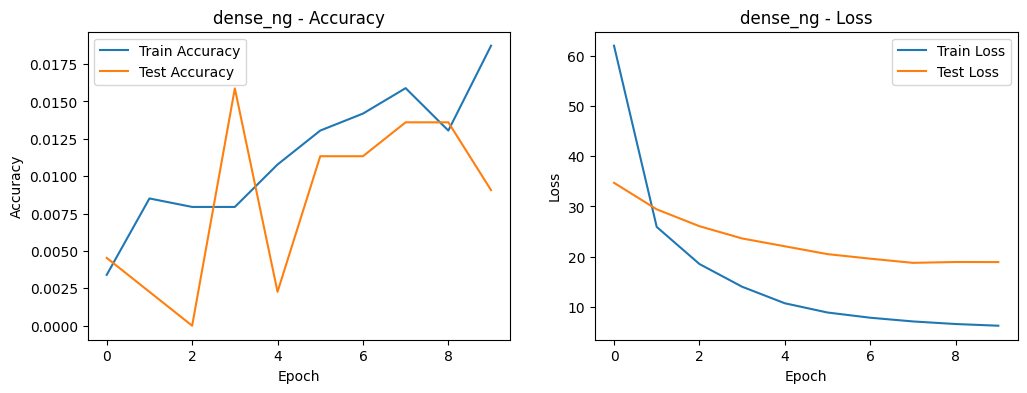

In [128]:
plot_results(dense_ng_hist, "dense_ng")

In [129]:
dense_ng.save(f"models/dense/ng_{percent_sample}.keras")

#### BoW

In [130]:
dense_bow = dense_model("sp", vocab_size)
dense_bow_hist = dense_bow.fit(
    X_train_bow, y_train_bow, epochs=20, validation_data=(X_test_bow, y_test_bow)
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0092 - loss: 6.8342 - val_accuracy: 0.0413 - val_loss: 6.7505
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0462 - loss: 6.5000 - val_accuracy: 0.0439 - val_loss: 6.4790
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0298 - loss: 5.8380 - val_accuracy: 0.0439 - val_loss: 6.5815
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0394 - loss: 5.4903 - val_accuracy: 0.0465 - val_loss: 6.6707
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0425 - loss: 5.1788 - val_accuracy: 0.0413 - val_loss: 6.7694
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0468 - loss: 4.9653 - val_accuracy: 0.0439 - val_loss: 6.8876
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0704 - loss: 4.6226 - val_accuracy: 0.0413 - val_loss: 6.9858
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0716 - loss: 4.3461 - val_accuracy: 0.0388 - val_loss:

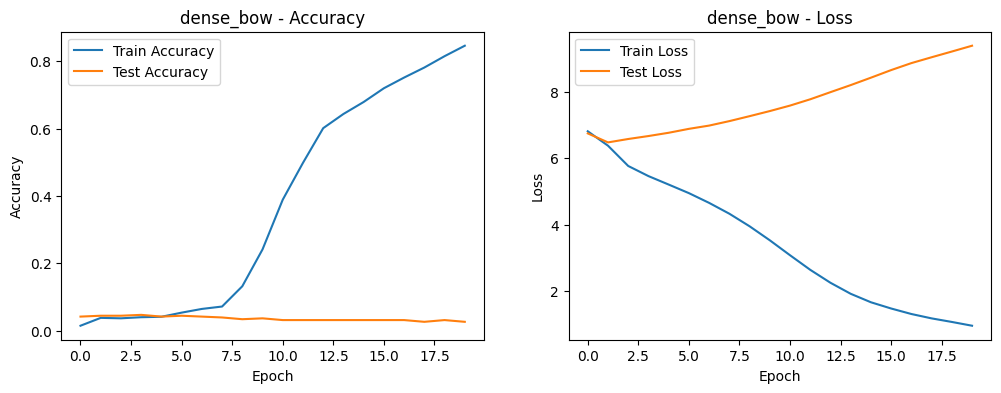

In [131]:
plot_results(dense_bow_hist, "dense_bow")

In [132]:
dense_bow.save(f"models/dense/bow_{percent_sample}.keras")

### RNN

#### Ngram

In [133]:
rnn_ng = rnn_model("sp", n_gram - 1)
rnn_ng_hist = rnn_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))


Epoch 1/10


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0127 - loss: 6.8310 - val_accuracy: 0.0272 - val_loss: 6.6245
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0348 - loss: 6.1389 - val_accuracy: 0.0181 - val_loss: 6.7038
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0472 - loss: 5.8340 - val_accuracy: 0.0227 - val_loss: 6.9260
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0848 - loss: 5.5915 - val_accuracy: 0.0204 - val_loss: 6.8896
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1456 - loss: 5.2149 - val_accuracy: 0.0249 - val_loss: 7.1302
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2111 - loss: 4.5707 - val_accuracy: 0.0249 - val_loss: 7.1369
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3439 - loss: 3.9005 - val_accuracy: 0.0249 - val_loss: 7.3270
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4838 - loss: 3.2264 - val_accuracy: 0.0227 - val_loss: 7.4263
Epo

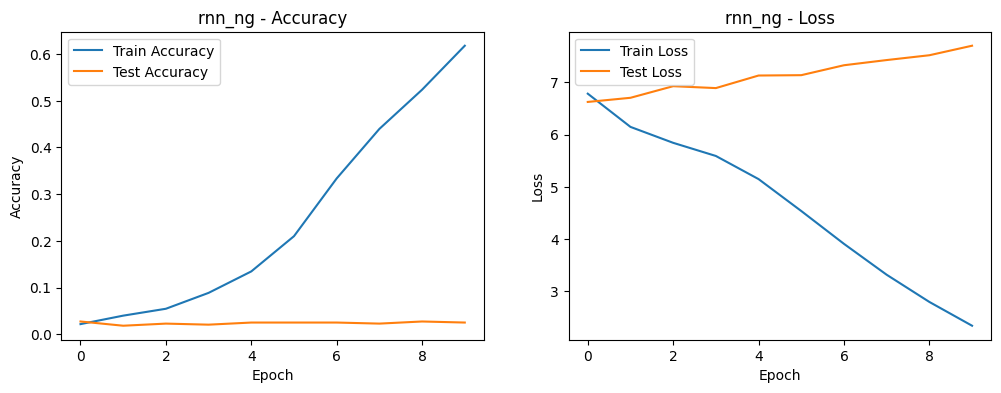

In [134]:
plot_results(rnn_ng_hist, "rnn_ng")


In [135]:
rnn_ng.save(f"models/rnn/ng_{percent_sample}.keras")

#### BoW

In [136]:
rnn_bow = rnn_model("sp", vocab_size)
rnn_bow_hist = rnn_bow.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.0135 - loss: 6.7664 - val_accuracy: 0.0362 - val_loss: 6.5164
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.0293 - loss: 6.2168 - val_accuracy: 0.0362 - val_loss: 6.7155
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.0376 - loss: 6.0972 - val_accuracy: 0.0362 - val_loss: 6.7818
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.0168 - loss: 6.0905 - val_accuracy: 0.0362 - val_loss: 6.8781
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.0279 - loss: 6.0569 - val_accuracy: 0.0362 - val_loss: 6.8582


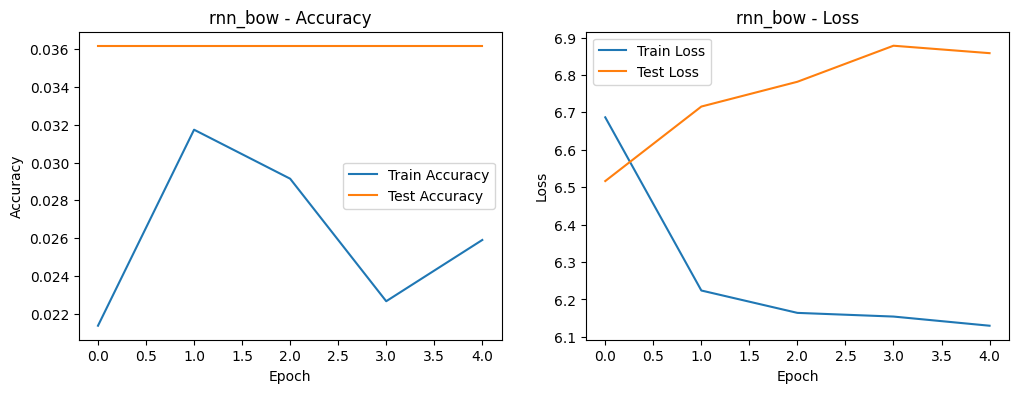

In [137]:
plot_results(rnn_bow_hist, "rnn_bow")

In [138]:
rnn_bow.save(f"models/rnn/bow_{percent_sample}.keras")

### GRU

#### Ngram

In [139]:
gru_ng = gru_model("sp", n_gram - 1)
gru_ng_hist = gru_ng.fit(X_train_ng, y_train_ng, epochs=20, validation_data=(X_test_ng, y_test_ng))


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0241 - loss: 6.8355 - val_accuracy: 0.0181 - val_loss: 6.6015
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0290 - loss: 6.2165 - val_accuracy: 0.0227 - val_loss: 6.7631
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0367 - loss: 5.9115 - val_accuracy: 0.0272 - val_loss: 6.8441
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0489 - loss: 5.8850 - val_accuracy: 0.0249 - val_loss: 7.0835
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0555 - loss: 5.7636 - val_accuracy: 0.0227 - val_loss: 7.0936
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0571 - loss: 5.6705 - val_accuracy: 0.0317 - val_loss: 7.2426
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0634 - loss: 5.5484 - val_accuracy: 0.0272 - val_loss: 7.4263
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0620 - loss: 5.3570 - val_accuracy: 0.0272 - val_loss

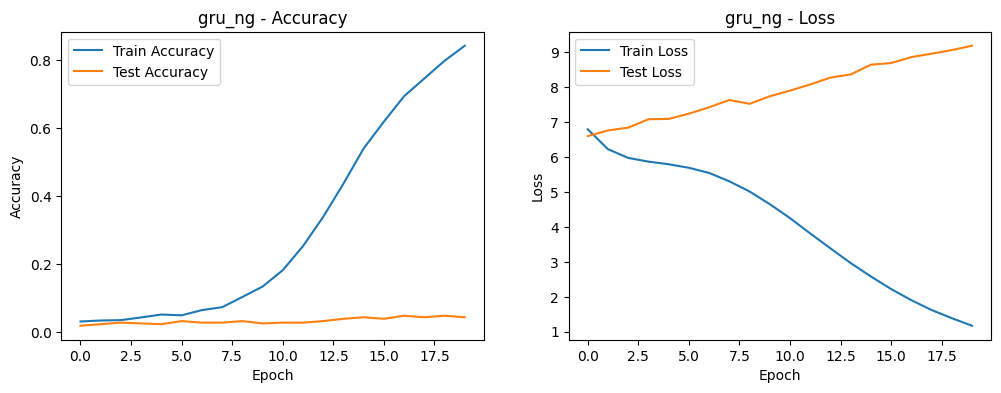

In [140]:
plot_results(gru_ng_hist, "gru_ng")


In [141]:
gru_ng.save(f"models/gru/ng_{percent_sample}.keras")

#### BoW

In [142]:
gru_bow = gru_model("sp", vocab_size)
gru_bow_hist = gru_bow.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 487ms/step - accuracy: 0.0230 - loss: 6.7797 - val_accuracy: 0.0413 - val_loss: 6.5109
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.0362 - loss: 6.1925 - val_accuracy: 0.0362 - val_loss: 6.6546
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.0376 - loss: 6.0655 - val_accuracy: 0.0362 - val_loss: 6.7490
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.0318 - loss: 6.1219 - val_accuracy: 0.0413 - val_loss: 6.9314
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.0223 - loss: 6.0930 - val_accuracy: 0.0413 - val_loss: 6.9418


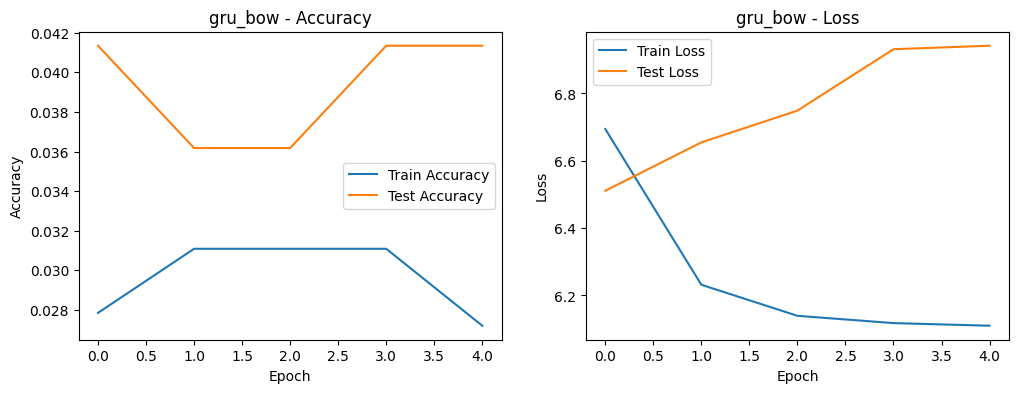

In [143]:
plot_results(gru_bow_hist, "gru_bow")

In [144]:
gru_bow.save(f"models/gru/bow_{percent_sample}.keras")

### LSTM

#### Ngram

In [145]:
lstm_ng = lstm_model("sp", n_gram - 1)
lstm_ng_hist = lstm_ng.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - accuracy: 0.0184 - loss: 6.7829 - val_accuracy: 0.0413 - val_loss: 6.4835
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 496ms/step - accuracy: 0.0263 - loss: 6.1841 - val_accuracy: 0.0413 - val_loss: 6.6100
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 496ms/step - accuracy: 0.0294 - loss: 6.1076 - val_accuracy: 0.0413 - val_loss: 6.7802
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - accuracy: 0.0316 - loss: 6.0822 - val_accuracy: 0.0413 - val_loss: 6.8044
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 518ms/step - accuracy: 0.0233 - loss: 6.0907 - val_accuracy: 0.0362 - val_loss: 6.9506


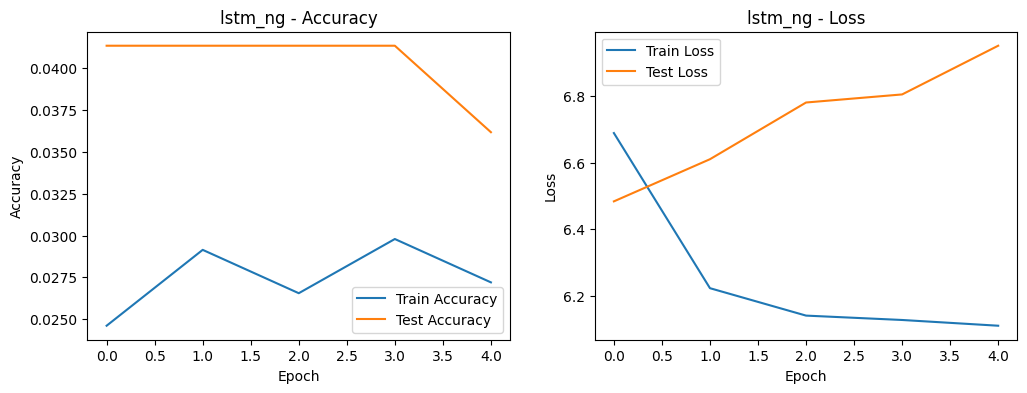

In [146]:
plot_results(lstm_ng_hist, "lstm_ng")

In [147]:
lstm_ng.save(f"models/lstm/ng_{percent_sample}.keras")

#### BoW

In [148]:
lstm_bow = lstm_model("sp", vocab_size)
lstm_bow_hist = lstm_bow.fit(X_train_bow, y_train_bow, epochs=10, validation_data=(X_test_bow, y_test_bow))

Epoch 1/10


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - accuracy: 0.0300 - loss: 6.7715 - val_accuracy: 0.0413 - val_loss: 6.4706
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 518ms/step - accuracy: 0.0262 - loss: 6.2310 - val_accuracy: 0.0413 - val_loss: 6.7819
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.0304 - loss: 6.1373 - val_accuracy: 0.0362 - val_loss: 6.7722
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.0328 - loss: 6.0916 - val_accuracy: 0.0413 - val_loss: 6.8098
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - accuracy: 0.0250 - loss: 6.1052 - val_accuracy: 0.0413 - val_loss: 6.9528
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.0212 - loss: 6.1223 - val_accuracy: 0.0362 - val_loss: 7.0341
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.0336 - loss: 6.0513 - val_accuracy: 0.0362 - val_loss: 6.9896
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.0399 - loss: 6.0779 - val_accuracy: 0.041

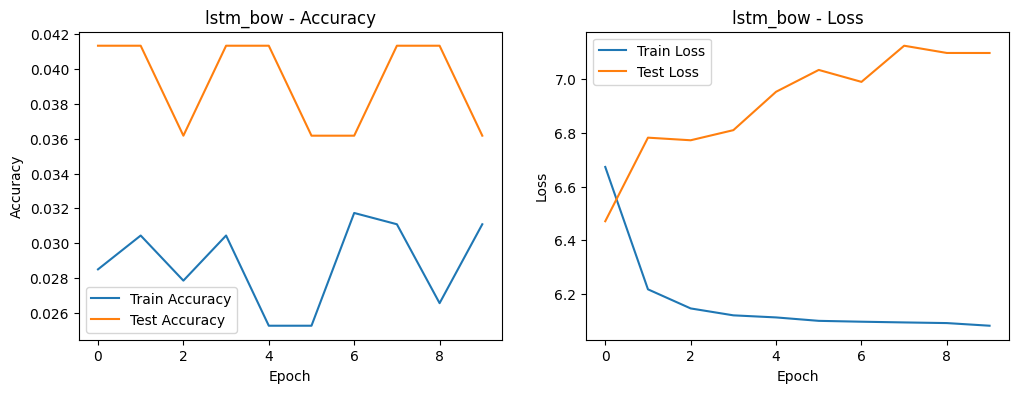

In [149]:
plot_results(lstm_bow_hist, "lstm_bow")

In [150]:
lstm_bow.save(f"models/lstm/bow_{percent_sample}.keras")

## Evaluation

In [151]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
def eval_bow(model, name):
    evaluate_model(model, X_test_bow, y_test_bow, name + "_bow")
    
def eval_ng(model, name):
    evaluate_model(model, X_test_ng, y_test_ng, name + "_ng")

In [152]:
eval_bow(dense_bow, "Dense")
eval_bow(rnn_bow, "RNN")
eval_bow(gru_bow, "GRU")
eval_bow(lstm_bow, "LSTM")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Dense_bow Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         4
          28       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         1
       

In [153]:
eval_ng(dense_ng, "Dense")
eval_ng(rnn_ng, "RNN")
eval_ng(gru_ng, "GRU")
eval_bow(lstm_ng, "LSTM")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Dense_ng Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         1
          32       0.00      0.00      0.00         2
        

# Word prediction

## Vars definition

In [170]:
want_percent = percent_sample

## Load models

In [171]:
dense_bow = load_model(f"models/dense/bow_{want_percent}.keras")
dense_ng = load_model(f"models/dense/ng_{want_percent}.keras")

gru_bow = load_model(f"models/gru/bow_{want_percent}.keras")
gru_ng = load_model(f"models/gru/ng_{want_percent}.keras")

rnn_bow = load_model(f"models/rnn/bow_{want_percent}.keras")
rnn_ng = load_model(f"models/rnn/ng_{want_percent}.keras")

lstm_bow = load_model(f"models/dense/bow_{want_percent}.keras")
lstm_ng= load_model(f"models/dense/ng_{want_percent}.keras")

## Functions

In [172]:
def generate_text(
    model, 
    seed_text, 
    word_to_idx, 
    idx_to_word, 
    mode="ngram", 
    num_words=5, 
    temperature=1.0, 
    top_k=5
):
    """
    Генерирует последовательность слов на основе начального текста.
    
    Parameters:
        model: обученная модель
        seed_text: начальный текст (строка)
        word_to_idx: словарь слово -> индекс
        idx_to_word: словарь индекс -> слово
        mode: "ngram" (RNN/GRU) или "bow"
        num_words: количество слов для генерации
        temperature: уровень случайности (0.1-2.0)
        top_k: выбор из топ-K вероятных слов
    """
    generated = seed_text.split()
    tokens = word_tokenize(seed_text.lower())
    tokens_idx = [word_to_idx.get(word, word_to_idx.get("<UNK>", 0)) for word in tokens]

    for _ in range(num_words):
        # Подготовка входных данных
        if mode == "bow":
            # window_size = 5
            context = tokens_idx[-window_size:]
            if len(context) < window_size:
                context = [0] * (window_size - len(context)) + context
            
            bow_vector = np.zeros(len(word_to_idx))
            for idx in context:
                bow_vector[idx] += 1
            input_data = bow_vector.reshape(1, -1)
            
        elif mode == "ngram":
            # n_gram = 3
            seq_length = n_gram - 1
            context = tokens_idx[-seq_length:]
            if len(context) < seq_length:
                context = [0] * (seq_length - len(context)) + context
            input_data = np.array([context])
        
        # Предсказание
        preds = model.predict(input_data, verbose=0)[0]
        preds = np.log(preds) / temperature  # Применяем температуру
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Выбор из топ-K слов
        top_indices = np.argpartition(preds, -top_k)[-top_k:]
        top_probs = preds[top_indices]
        top_probs = top_probs / np.sum(top_probs)  # Нормализуем
        
        # Сэмплирование
        chosen_idx = np.random.choice(top_indices, p=top_probs)
        chosen_word = idx_to_word.get(chosen_idx, "<UNK>")
        
        # Обновляем контекст
        generated.append(chosen_word)
        tokens_idx.append(chosen_idx)

    return " ".join(generated)

In [173]:
def test_gen(
    sentence: str,
    words: int,
    top_k: int,
):
    bow_d = generate_text(
        dense_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_g = generate_text(
        gru_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_r = generate_text(
        rnn_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_l = generate_text(
        lstm_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )

    ng_d = generate_text(
        dense_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_g = generate_text(
        gru_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_r = generate_text(
        rnn_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_l = generate_text(
        lstm_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )

    print("BOW:")
    print("dense:\t" + bow_d)
    print("gru:\t" + bow_g)
    print("rnn:\t" + bow_r)
    print("ltsm:\t" + bow_l)

    print()

    print("NGRAM:")
    print("dense:\t" + ng_d)
    print("gru:\t" + ng_g)
    print("rnn:\t" + ng_r)
    print("ltsm:\t" + ng_l)

## Tests

In [174]:
input_sentence = "I love this model for"

test_gen(input_sentence, 5, 3)

C:\Users\artem\AppData\Local\Temp\ipykernel_6348\3261994695.py:51: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature  # Применяем температуру


BOW:
dense:	I love this model for performance 2 good 2 2
gru:	I love this model for good laptop good laptop laptop
rnn:	I love this model for battery good good good good
ltsm:	I love this model for 2 2 laptop driver causing

NGRAM:
dense:	I love this model for good shutdown heavy mark display
gru:	I love this model for okk okk overall work product
rnn:	I love this model for product bit one good display
ltsm:	I love this model for good mentioned performance get good
